In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
from paths import *
import matplotlib.pyplot as plt

In [8]:
data_summary_path = '/nfs/attic/dfh/data/snodas/dailyclim/'
data_path = '/nfs/attic/dfh/data/snodas/snodas_download/'#yyyy/dd-mmm/Hs/
cso_data_path = '/nfs/attic/dfh/Aragon2/snow_change_from_dave/cso-data.geojson'

In [127]:
csodf = gpd.read_file(cso_data_path)
#csodf = csodf[0:5]
csodf

,id,author,depth,source,timestamp,elevation,_ms,geometry
0,uW1g0dAo,James Molloy,190.0,MountainHub,2019-04-13T02:25:06,2936.050537,1555122306435,POINT (-110.06545 43.75285)
1,su7tnS0Q,Brooks Taylor,118.0,MountainHub,2019-01-20T20:45:35,2322.340088,1548017135391,POINT (-110.68357 44.05567)
2,oLinNVH0,Brooks Taylor,110.0,MountainHub,2019-01-20T17:30:22,2313.090332,1548005422802,POINT (-110.68245 44.05640)
3,o9KCw9be,James Molloy,187.0,MountainHub,2019-01-12T19:52:14,2588.510742,1547322734262,POINT (-110.78295 43.71575)
4,42FrqUY+,James Molloy,208.0,MountainHub,2019-03-03T22:15:10,2246.562988,1551651310107,POINT (-110.76157 43.71568)
...,...,...,...,...,...,...,...,...
223,+cHuTfsk,Celine Jaccard,150.0,SnowPilot,2019-01-22T08:10:00,2436.658203,1548144600000,POINT (-110.95320 43.48429)
224,DymAudqU,Sam Rogers,170.0,SnowPilot,2019-02-01T20:40:00,2516.089355,1549053600000,POINT (-110.95953 43.48326)
225,UMUVMTlQ,Mark Staples,147.0,SnowPilot,2019-02-08T09:00:00,2805.057129,1549616400000,POINT (-112.40497 38.20270)
226,WoX30vJN,Drew Nehrenz,66.0,SnowPilot,2019-01-19T22:00:00,2870.665527,1547935200000,POINT (-112.34843 38.32089)


In [173]:
test_file = '/nfs/attic/dfh/data/snodas/dailyclim/01011034max.dat'

In [128]:

def get_snodas_point(inlat, inlon, date, var):
    '''
    This function will extract 
    
    var = 'Hs' or 'SWE'
    '''
    # Build file name from date 
    if var == 'Hs':
        Fname = '/nfs/attic/dfh/data/snodas/snodas_download/'+date.strftime("%Y")+'/'+date.strftime("%m")+'_'+date.strftime("%b")+'/Hs/us_ssmv11036tS__T0001TTNATS'+date.strftime("%Y")+date.strftime("%m")+date.strftime("%d")+'05HP001.dat'
        min_Fname = '/nfs/attic/dfh/data/snodas/dailyclim/'+date.strftime("%m")+date.strftime("%d")+'1036min.dat'
        max_Fname = '/nfs/attic/dfh/data/snodas/dailyclim/'+date.strftime("%m")+date.strftime("%d")+'1036max.dat'
        mean_Fname = '/nfs/attic/dfh/data/snodas/dailyclim/'+date.strftime("%m")+date.strftime("%d")+'1036mean.dat'
    elif var == 'SWE':
        Fname = '/nfs/attic/dfh/data/snodas/snodas_download/'+date.strftime("%Y")+'/'+date.strftime("%m")+'_'+date.strftime("%b")+'/SWE/us_ssmv11034tS__T0001TTNATS'+date.strftime("%Y")+date.strftime("%m")+date.strftime("%d")+'05HP001.dat'
        min_Fname = '/nfs/attic/dfh/data/snodas/dailyclim/'+date.strftime("%m")+date.strftime("%d")+'1034min.dat'
        max_Fname = '/nfs/attic/dfh/data/snodas/dailyclim/'+date.strftime("%m")+date.strftime("%d")+'1034max.dat'
        mean_Fname = '/nfs/attic/dfh/data/snodas/dailyclim/'+date.strftime("%m")+date.strftime("%d")+'1034mean.dat'
        
    # Build lat lon grid for snodas data 
    # This info comes from the metadata on the SNODAS project
    ncols=6935
    nrows=3351
    cellsize=0.008333333333333 # grid resolution in deg
    ULlat=52.871249516804028 # center of upper left cell (lat)
    ULlon=-124.729583333331703 # center of upper left cell (lon)
    #lats = np.linspace(ULlat-cellsize*nrows,ULlat,nrows)
    lats = np.flipud(np.linspace(ULlat-cellsize*nrows,ULlat,nrows))
    lons = np.linspace(ULlon,ULlon+cellsize*ncols,ncols)
    ln,lt =np.meshgrid(lons,lats)
    ln = ln.flatten()
    lt = lt.flatten()
    
    # Find index of point of interest
    idx = np.where((np.abs(lt-inlat)==np.abs(lt-inlat).min())&(np.abs(ln-inlon)==np.abs(ln-inlon).min()))[0][0]
    
    # Extract data from snodas
    grads_data = open(Fname,'rb')
    # snodas data is 16 bit signed integers 
    # offset is in bytes, since 8 bits in 1 byte, need to multiply the index by 2
    # count indicates the number of items to read (-1 indicates read the whole file)
    data = np.fromfile(grads_data,dtype='>i2',count = 1,offset=2*(idx))
    grads_data.close()
    
    # Extract daily snodas climatology 
    grads_data = open(min_Fname,'rb')
    min_data = np.fromfile(grads_data,dtype='>i2',count = 1,offset=2*idx)
    grads_data.close()
    grads_data = open(max_Fname,'rb')
    max_data = np.fromfile(grads_data,dtype='>i2',count = 1,offset=2*idx)
    grads_data.close()
    grads_data = open(mean_Fname,'rb')
    mean_data = np.fromfile(grads_data,dtype='>i2',count = 1,offset=2*idx)
    grads_data.close()
    
    return data[0], min_data[0], max_data[0], mean_data[0]

In [129]:
dates = pd.to_datetime(csodf['timestamp'], format='%Y-%m-%dT%H:%M:%S')

Hs_data = []
Hs_min = []
Hs_max = []
Hs_mean = []
for i in range(len(dates)):
    date = dates[i]
    inlat = csodf.geometry.y[i]
    inlon = csodf.geometry.x[i]
    data, min_data, max_data, mean_data = get_snodas_point(inlat, inlon, date, 'Hs')
    Hs_data.append(data)
    Hs_min.append(min_data)
    Hs_max.append(max_data)
    Hs_mean.append(mean_data)

In [130]:
csodf['snodas_hs'] = Hs_data
csodf['snodas_min'] = Hs_min
csodf['snodas_max'] = Hs_max
csodf['snodas_mean'] = Hs_mean


In [131]:
csodf

,id,author,depth,source,timestamp,elevation,_ms,geometry,snodas_hs,snodas_min,snodas_max,snodas_mean
0,uW1g0dAo,James Molloy,190.0,MountainHub,2019-04-13T02:25:06,2936.050537,1555122306435,POINT (-110.06545 43.75285),1630,1230,3117,2034
1,su7tnS0Q,Brooks Taylor,118.0,MountainHub,2019-01-20T20:45:35,2322.340088,1548017135391,POINT (-110.68357 44.05567),838,835,1919,1217
2,oLinNVH0,Brooks Taylor,110.0,MountainHub,2019-01-20T17:30:22,2313.090332,1548005422802,POINT (-110.68245 44.05640),887,836,2027,1246
3,o9KCw9be,James Molloy,187.0,MountainHub,2019-01-12T19:52:14,2588.510742,1547322734262,POINT (-110.78295 43.71575),1447,691,3344,1659
4,42FrqUY+,James Molloy,208.0,MountainHub,2019-03-03T22:15:10,2246.562988,1551651310107,POINT (-110.76157 43.71568),2045,999,2087,1627
...,...,...,...,...,...,...,...,...,...,...,...,...
223,+cHuTfsk,Celine Jaccard,150.0,SnowPilot,2019-01-22T08:10:00,2436.658203,1548144600000,POINT (-110.95320 43.48429),1230,1000,1975,1423
224,DymAudqU,Sam Rogers,170.0,SnowPilot,2019-02-01T20:40:00,2516.089355,1549053600000,POINT (-110.95953 43.48326),1162,1046,1870,1491
225,UMUVMTlQ,Mark Staples,147.0,SnowPilot,2019-02-08T09:00:00,2805.057129,1549616400000,POINT (-112.40497 38.20270),1453,282,1453,826
226,WoX30vJN,Drew Nehrenz,66.0,SnowPilot,2019-01-19T22:00:00,2870.665527,1547935200000,POINT (-112.34843 38.32089),1110,238,1662,891


Text(0.5, 1.0, 'snodas - cso')

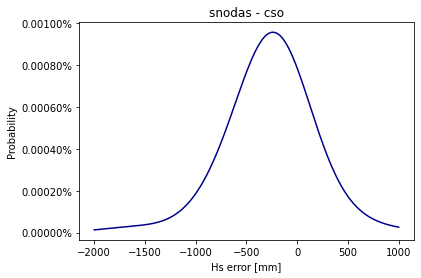

In [160]:
from matplotlib.ticker import PercentFormatter
from scipy import stats

fig, axs = plt.subplots(1)  
data = csodf.snodas_hs - csodf.depth.values*10
kde = stats.gaussian_kde(data)
x1 = np.arange(-2000,1001)#np.linspace(data.min(), data.max(), 100)
p1 = kde(x1)

axs.plot(x1,p1,color = 'darkblue',label='snodas-cso Hs')

axs.yaxis.set_major_formatter(PercentFormatter(xmax=100))

#plt.legend()
plt.ylabel('Probability')
plt.xlabel('Hs error [mm]')
plt.title('snodas - cso')

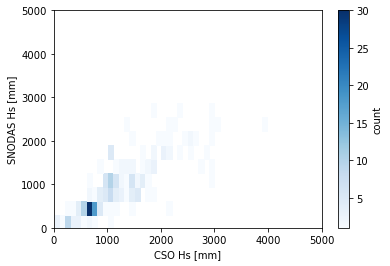

In [152]:
plt.hist2d(x, y, bins=40, cmap='Blues',cmin=1)
plt.ylabel('SNODAS Hs [mm]')
plt.ylim([0,5000])
plt.xlabel('CSO Hs [mm]')
plt.xlim([0,5000])
cb = plt.colorbar()
cb.set_label('count')

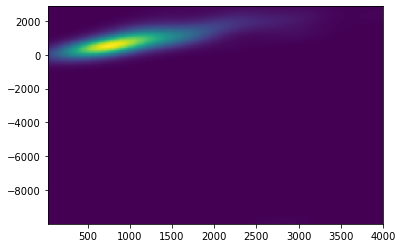

In [162]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kde
 
# create data
x = csodf.depth.values*10
y = csodf.snodas_hs
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
plt.show()
 
# # Change color palette
# plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=plt.cm.Greens_r)
# plt.show()

In [64]:
nx = 6935
ny = 3351
#open the grads model output file, 'rb' indicates reading from binary file
grads_data = open(test_file,'rb')
# convert to a numpy array 
numpy_data = np.fromfile(grads_data,dtype='>i2',count=-1)
#close grads file 
grads_data.close()
#reshape the data
#numpy_data = np.reshape(numpy_data,(1,ny,nx))
print(numpy_data[3405435])
numpy_data.shape

32767


(23239185,)

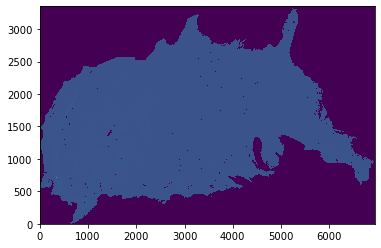

In [178]:
plt.pcolormesh(np.squeeze(numpy_data));

In [2]:
st = ['2018-12-25']
ed = ['2019-12-24']

In [3]:
def get_cso(st, ed, Bbox):
    #Issue CSO API observations request and load the results into a GeoDataFrame
    params = {
      "bbox": f"{Bbox['lonmin']},{Bbox['latmax']},{Bbox['lonmax']},{Bbox['latmin']}",
      "start_date": st,
      "end_date": ed,
      "format": "geojson",
      "limit": 5000,
    }

    csodata_resp = requests.get("https://api.communitysnowobs.org/observations", params=params)
    csodatajson = csodata_resp.json()
    #turn into geodataframe
    gdf = gpd.GeoDataFrame.from_features(csodatajson, crs=stn_proj)
    
    mask = (gdf['timestamp'] >= st) & (gdf['timestamp'] <= ed)
    gdf = gdf.loc[mask]
    gdf=gdf.reset_index(drop=True)
    print('Total number of CSO in domain = ',len(gdf))
    
#     ingdf = extract_meta(gdf,mod_proj,dem_path,lc_path)
    
#     #need to format data for Hs_to_SWE conversion
#     ingdf['dt'] = pd.to_datetime(ingdf['timestamp'], format='%Y-%m-%dT%H:%M:%S')
#     ingdf['dt'] = pd.to_datetime(ingdf['dt']).dt.date
#     ingdf['Y'] = pd.DatetimeIndex(ingdf['dt']).year
#     ingdf['M'] = pd.DatetimeIndex(ingdf['dt']).month
#     ingdf['D'] = pd.DatetimeIndex(ingdf['dt']).day
#     ingdf["LON"] = ingdf.geometry.x
#     ingdf["LAT"] = ingdf.geometry.y
#     ingdf=ingdf.drop(columns=['dt'])
    
#     #convert snow depth to mm to input into density function
#     ingdf['H'] = ingdf.depth*10
#     ingdf.head()
    
#     #Hs to SWE
#     SWE,DOY = swe_calc(ingdf.Y.values,ingdf.M.values,ingdf.D.values,ingdf.H.values,ingdf.LAT.values,ingdf.LON.values)
    
#     #convert swe to m to input into SM
#     ingdf['swe']=SWE/1000
#     ingdf['doy']=DOY
    return gdf


In [4]:
for i in range(len(st)):
    
    csodf = get_cso(st[i], ed[i], Bbox)
    
csodf

Total number of CSO in domain =  222


,geometry,id,author,depth,source,timestamp,elevation
0,POINT (-110.98488 43.49086),ySM25tVp,Allen OBannon,105.00,MountainHub,2019-12-23T19:53:47.163Z,2532.504883
1,POINT (-110.94908 43.48673),iQmktvUg,Allen OBannon,125.00,MountainHub,2019-12-21T21:16:08.240Z,2558.997803
2,POINT (-110.94630 43.48830),yxGpBU4N,Allen OBannon,85.00,MountainHub,2019-12-21T20:31:25.887Z,2521.308350
3,POINT (-110.98569 43.70119),n1lfrb1t,Katie O’Connell,30.48,MountainHub,2019-11-16T19:34:07.376Z,2707.184814
4,POINT (-111.06764 43.69510),WlKPTkn5,Teton Valley,3.00,MountainHub,2019-10-28T15:08:20.818Z,1922.723145
...,...,...,...,...,...,...,...
217,POINT (-110.92160 43.50979),+UhGA+OO,Lisa Van Sciver,70.00,SnowPilot,2018-12-26T22:00:00.000Z,2464.140137
218,POINT (-110.86513 43.26662),+34WozHH,John Wauters,155.00,SnowPilot,2018-12-26T19:00:00.000Z,2278.290527
219,POINT (-110.86109 43.25680),uco0ulMr,John Wauters,135.00,SnowPilot,2018-12-26T18:00:00.000Z,2259.148438
220,POINT (-110.87596 43.59121),GzV3FFCn,Bill Dyer,240.00,SnowPilot,2018-12-25T18:30:00.000Z,3018.223145


In [73]:

def get_snodas_point(inlat, inlon, date, var):
    '''
    This function will extract 
    
    var = 'Hs' or 'SWE'
    '''
    # Build file name from date 
    if var == 'Hs':
        Fname = '/nfs/attic/dfh/data/snodas/snodas_download/'+date.strftime("%Y")+'/'+date.strftime("%m")+'_'+date.strftime("%b")+'/Hs/us_ssmv11036tS__T0001TTNATS'+date.strftime("%Y")+date.strftime("%m")+date.strftime("%d")+'05HP001.dat'
        min_Fname = '/nfs/attic/dfh/data/snodas/dailyclim/'+date.strftime("%m")+date.strftime("%d")+'1036min.dat'
        max_Fname = '/nfs/attic/dfh/data/snodas/dailyclim/'+date.strftime("%m")+date.strftime("%d")+'1036max.dat'
        mean_Fname = '/nfs/attic/dfh/data/snodas/dailyclim/'+date.strftime("%m")+date.strftime("%d")+'1036mean.dat'
    elif var == 'SWE':
        Fname = '/nfs/attic/dfh/data/snodas/snodas_download/'+date.strftime("%Y")+'/'+date.strftime("%m")+'_'+date.strftime("%b")+'/SWE/us_ssmv11034tS__T0001TTNATS'+date.strftime("%Y")+date.strftime("%m")+date.strftime("%d")+'05HP001.dat'
        min_Fname = '/nfs/attic/dfh/data/snodas/dailyclim/'+date.strftime("%m")+date.strftime("%d")+'1034min.dat'
        max_Fname = '/nfs/attic/dfh/data/snodas/dailyclim/'+date.strftime("%m")+date.strftime("%d")+'1034max.dat'
        mean_Fname = '/nfs/attic/dfh/data/snodas/dailyclim/'+date.strftime("%m")+date.strftime("%d")+'1034mean.dat'
        
    # Build lat lon grid for snodas data 
    # This info comes from the metadata on the SNODAS project
    ncols=6935
    nrows=3351
    cellsize=0.008333333333333 # grid resolution in deg
    ULlat=52.871249516804028 # center of upper left cell (lat)
    ULlon=-124.729583333331703 # center of upper left cell (lon)
    #lats = np.linspace(ULlat-cellsize*nrows,ULlat,nrows)
    lats = np.flipud(np.linspace(ULlat-cellsize*nrows,ULlat,nrows))
    lons = np.linspace(ULlon,ULlon+cellsize*ncols,ncols)
#     ln,lt =np.meshgrid(lons,lats)
#     ln = ln.flatten()
#     lt = lt.flatten()
    
    # Find index of point of interest
    idx_lt = np.where(np.abs(lats-inlat)==np.abs(lats-inlat).min())[0][0]
    idx_ln = np.where(np.abs(lons-inlon)==np.abs(lons-inlon).min())[0][0]
    idx = (idx_ln)*ncols+(idx_lt)
    
    # Extract data from snodas
    grads_data = open(Fname,'rb')
    # snodas data is 16 bit signed integers 
    # offset is in bytes, since 8 bits in 1 byte, need to multiply the index by 2
    # count indicates the number of items to read (-1 indicates read the whole file)
    data = np.fromfile(grads_data,dtype='>i2',count = 1,offset=2*(idx))
    grads_data.close()
    
    # Extract daily snodas climatology 
    grads_data = open(min_Fname,'rb')
    min_data = np.fromfile(grads_data,dtype='>i2',count = 1,offset=2*idx)
    grads_data.close()
    grads_data = open(max_Fname,'rb')
    max_data = np.fromfile(grads_data,dtype='>i2',count = 1,offset=2*idx)
    grads_data.close()
    grads_data = open(mean_Fname,'rb')
    mean_data = np.fromfile(grads_data,dtype='>i2',count = 1,offset=2*idx)
    grads_data.close()
    
    return data, min_data, max_data, mean_data#data[0], min_data[0], max_data[0], mean_data[0]